In [896]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix
import copy

In [897]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [898]:
task_3_data = pd.read_csv("/content/drive/MyDrive/fodltemp/Task3_updated/team11/training_data_set_11_labeled_data.csv", header = None)
task_3_label = pd.read_csv("/content/drive/MyDrive/fodltemp/Task3_updated/team11/training_data_set_11_labeled_labels.csv", header = None)
task_3_unlabeled = pd.read_csv("/content/drive/MyDrive/fodltemp/Task3_updated/team11/training_data_set_11_unlabeled.csv", header = None)

In [899]:
print(task_3_label.shape)
print(task_3_data.shape)
print(task_3_unlabeled.shape)

(750, 1)
(750, 36)
(1750, 36)


In [900]:
class AEC(nn.Module):

    def __init__(self,in_dim,hid_dim,mid_dim):
        super(AEC, self).__init__()
        self.enc1 = nn.Linear(in_dim, hid_dim)
        self.enc2 = nn.Linear(hid_dim, mid_dim)
        self.dec2 = nn.Linear(mid_dim, hid_dim)
        self.dec1 = nn.Linear(hid_dim, in_dim)

    def forward(self, inp):
      tan = nn.Tanh()
      hid = tan(self.enc1(inp))
      hid = self.enc2(hid)
      hid = tan(self.dec2(hid))
      out = self.dec1(hid)
      return out

    def encode(self, inp):
      tan = nn.Tanh()
      hid = tan(self.enc1(inp))
      hid = self.enc2(hid)
      return hid

aec = AEC(5,4,3)
print(aec)

AEC(
  (enc1): Linear(in_features=5, out_features=4, bias=True)
  (enc2): Linear(in_features=4, out_features=3, bias=True)
  (dec2): Linear(in_features=3, out_features=4, bias=True)
  (dec1): Linear(in_features=4, out_features=5, bias=True)
)


In [901]:
aec1 = AEC(36,28,20)
aec2 = AEC(20,17,13)
aec3 = AEC(13,10,7)

In [902]:
def train_aec(model : AEC, input):
  criterion = nn.MSELoss()
  lr = 0.015
  batch_size = (int) (input.shape[0]/10)
  dataloader = torch.utils.data.DataLoader(input, batch_size=batch_size, shuffle=True)
  stopping_criteria = 0.0000001
  optimizer = torch.optim.Adam(model.parameters(), lr = lr)
  update_array = []
  loss_arr = []
  epoch = 0
  prev_epoch_avg_loss = 0
  current_epoch_avg_loss = 10
  change = abs(current_epoch_avg_loss - prev_epoch_avg_loss)
  while change > stopping_criteria:
    epoch_loss = 0

    for batch in dataloader:
      optimizer.zero_grad()
      reconstructed = model.forward(batch)
      loss = criterion(reconstructed, batch)  # Compute loss for each mini-batch
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
    loss_arr.append(epoch_loss / len(dataloader))
    prev_epoch_avg_loss = current_epoch_avg_loss

    current_epoch_avg_loss = epoch_loss / len(dataloader)
    change = abs(current_epoch_avg_loss - prev_epoch_avg_loss)
    if epoch % 10 == 0:
      print(f"Epoch {epoch+1}, Loss: {loss_arr[-1]:.8f}")
    epoch += 1

  print(f"Trained for {epoch} epochs.")
  print(f"Final loss: {loss_arr[-1]:.8f}")

In [903]:
unl_data = task_3_unlabeled.values
data_tensor = torch.tensor(unl_data, dtype=torch.float32)

In [904]:
train_aec(aec1, data_tensor)
next_data_tensor = aec1.encode(data_tensor).detach()
print(next_data_tensor.shape)

Epoch 1, Loss: 0.01264422
Epoch 11, Loss: 0.00225811
Epoch 21, Loss: 0.00155503
Epoch 31, Loss: 0.00122082
Epoch 41, Loss: 0.00116196
Epoch 51, Loss: 0.00113462
Epoch 61, Loss: 0.00112462
Epoch 71, Loss: 0.00111434
Epoch 81, Loss: 0.00111517
Epoch 91, Loss: 0.00112363
Epoch 101, Loss: 0.00111397
Epoch 111, Loss: 0.00110610
Epoch 121, Loss: 0.00110686
Epoch 131, Loss: 0.00109845
Trained for 138 epochs.
Final loss: 0.00110837
torch.Size([1750, 20])


In [905]:
train_aec(aec2, next_data_tensor)
next_data_tensor = aec2.encode(next_data_tensor).detach()

Epoch 1, Loss: 0.02152468
Epoch 11, Loss: 0.00241205
Epoch 21, Loss: 0.00181779
Epoch 31, Loss: 0.00173433
Epoch 41, Loss: 0.00170560
Epoch 51, Loss: 0.00169352
Epoch 61, Loss: 0.00169715
Epoch 71, Loss: 0.00170187
Epoch 81, Loss: 0.00169878
Epoch 91, Loss: 0.00169725
Epoch 101, Loss: 0.00170068
Epoch 111, Loss: 0.00169541
Epoch 121, Loss: 0.00167943
Trained for 127 epochs.
Final loss: 0.00168888


In [906]:
train_aec(aec3, next_data_tensor)

Epoch 1, Loss: 0.03151247
Epoch 11, Loss: 0.00705150
Epoch 21, Loss: 0.00587832
Epoch 31, Loss: 0.00584658
Epoch 41, Loss: 0.00584038
Epoch 51, Loss: 0.00582781
Epoch 61, Loss: 0.00583220
Trained for 69 epochs.
Final loss: 0.00582977


In [907]:
unl_data = task_3_unlabeled.values
data_tensor = torch.tensor(unl_data, dtype=torch.float32)
print(data_tensor.shape)
print(data_tensor.shape[0]/10)

torch.Size([1750, 36])
175.0


In [908]:
class DFNNwithprt(nn.Module):
  def __init__(self):
    super(DFNNwithprt, self).__init__()
    self.lay1 = copy.deepcopy(aec1.enc1)
    self.lay2 = copy.deepcopy(aec1.enc2)
    self.lay3 = copy.deepcopy(aec2.enc1)
    self.lay4 = copy.deepcopy(aec2.enc2)
    self.lay5 = copy.deepcopy(aec3.enc1)
    self.lay6 = copy.deepcopy(aec3.enc2)
    self.out_layer = nn.Linear(7, 5)

  def forward(self,inp):
    tan = nn.Tanh()
    hid1 = tan(self.lay1(inp))
    hid2 = self.lay2(hid1)
    hid3 = tan(self.lay3(hid2))
    hid4 = self.lay4(hid3)
    hid5 = tan(self.lay5(hid4))
    hid6 = self.lay6(hid5)

    out = self.out_layer(hid6)

    return out

In [909]:
def train_dfnn(model, input,labels):
  criterion = nn.CrossEntropyLoss()
  lr = 0.0005
  batch_size = input.shape[0]//10
  labels = labels.squeeze()
  dtset = torch.utils.data.TensorDataset(input, labels)
  dataloader = torch.utils.data.DataLoader(dtset, batch_size=batch_size, shuffle=True)
  stopping_criteria = 0.0001
  optimizer = torch.optim.Adam(model.parameters(), lr = lr)
  update_array = []
  loss_arr = []
  epoch = 0
  prev_epoch_avg_loss = 0
  current_epoch_avg_loss = 10
  change = abs(current_epoch_avg_loss - prev_epoch_avg_loss)
  while change > stopping_criteria:
    epoch_loss = 0

    for batch_in,batch_lbl in dataloader:
      optimizer.zero_grad()
      reconstructed = model(batch_in)
      loss = criterion(reconstructed, batch_lbl)  # Compute loss for each mini-batch
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
    loss_arr.append(epoch_loss / len(dataloader))
    prev_epoch_avg_loss = current_epoch_avg_loss

    current_epoch_avg_loss = epoch_loss / len(dataloader)
    change = abs(current_epoch_avg_loss - prev_epoch_avg_loss)
    if epoch % 10 == 0:
      print(f"Epoch {epoch+1}, Loss: {loss_arr[-1]:.8f}")
    epoch += 1

  print(f"Trained for {epoch} epochs.")
  print(f"Final loss: {loss_arr[-1]:.8f}")

In [910]:
class DFNN(nn.Module):
  def __init__(self):
    super(DFNN, self).__init__()
    self.lay1 = nn.Linear(36,28)
    self.lay2 = nn.Linear(28,17)
    self.lay3 = nn.Linear(17,10)
    self.out_layer = nn.Linear(10, 5)
  def forward(self,inp):
    tan = nn.Tanh()
    sft = nn.Softmax()
    hid1 = tan(self.lay1(inp))
    hid2 = tan(self.lay2(hid1))
    hid3 = tan(self.lay3(hid2))
    out = self.out_layer(hid3)
    return out

In [911]:
def confusion_matrix_train(model,dat,val):
  x_train = torch.tensor(dat.values, dtype=torch.float32)  # Use .values to extract raw data
  y_train_true = torch.tensor(val.values, dtype=torch.float32)  # Use .values to extract raw data

  # Assuming you have a trained model and training datas
  y_train_pred = model.forward(x_train).detach()  # Model predictions

  # If the output is probability scores, convert to class labels
  y_train_pred = np.argmax(y_train_pred, axis=1)

  # Compute confusion matrix
  cm = confusion_matrix(y_train_true, y_train_pred)
  print("Accuracy:", np.trace(cm)/np.sum(cm))

  # Plot confusion matrix
  plt.figure(figsize=(6, 5))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_train_true), yticklabels=np.unique(y_train_true))
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title("Confusion Matrix (Train Data)")
  plt.show()

In [912]:
wdfnn = DFNNwithprt()
dfnn = DFNN()

In [913]:
l_data = task_3_data.values
ldata_tensor = torch.tensor(l_data, dtype=torch.float32)
# print(ldata_tensor.shape)
l_label = task_3_label.values
labels_tensor = torch.tensor(l_label, dtype=torch.long)
# print(labels_tensor.shape)


In [914]:
train_dfnn(wdfnn, ldata_tensor, labels_tensor.detach())

Epoch 1, Loss: 1.65642545
Epoch 11, Loss: 1.50849935
Epoch 21, Loss: 1.28265638
Epoch 31, Loss: 1.16001623
Epoch 41, Loss: 1.11716662
Epoch 51, Loss: 1.09352415
Epoch 61, Loss: 1.07502795
Epoch 71, Loss: 1.05913392
Epoch 81, Loss: 1.04346785
Epoch 91, Loss: 1.03325009
Epoch 101, Loss: 1.02223017
Epoch 111, Loss: 1.01259053
Epoch 121, Loss: 1.00788355
Epoch 131, Loss: 0.99500126
Epoch 141, Loss: 0.98859966
Epoch 151, Loss: 0.98150076
Epoch 161, Loss: 0.97434959
Epoch 171, Loss: 0.96941342
Epoch 181, Loss: 0.96152964
Epoch 191, Loss: 0.95485687
Epoch 201, Loss: 0.94923526
Epoch 211, Loss: 0.94249696
Trained for 214 epochs.
Final loss: 0.94621216


In [915]:
train_dfnn(dfnn, ldata_tensor, labels_tensor.detach())

Epoch 1, Loss: 1.62708014
Epoch 11, Loss: 1.59680353
Epoch 21, Loss: 1.51962636
Epoch 31, Loss: 1.36967502
Epoch 41, Loss: 1.29404814
Epoch 51, Loss: 1.23453330
Epoch 61, Loss: 1.19836762
Epoch 71, Loss: 1.17677290
Trained for 73 epochs.
Final loss: 1.17440505


Accuracy: 0.6186666666666667


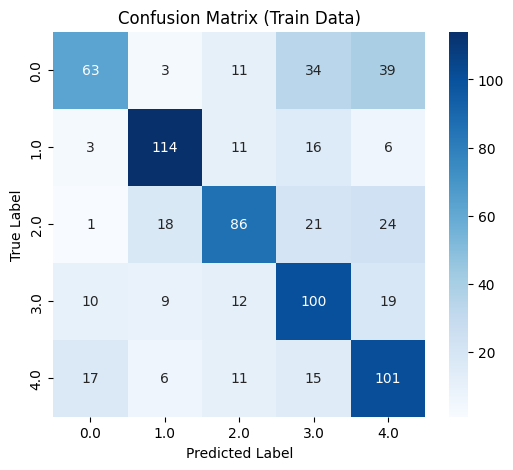

In [916]:
confusion_matrix_train(wdfnn,task_3_data,task_3_label)

Accuracy: 0.5253333333333333


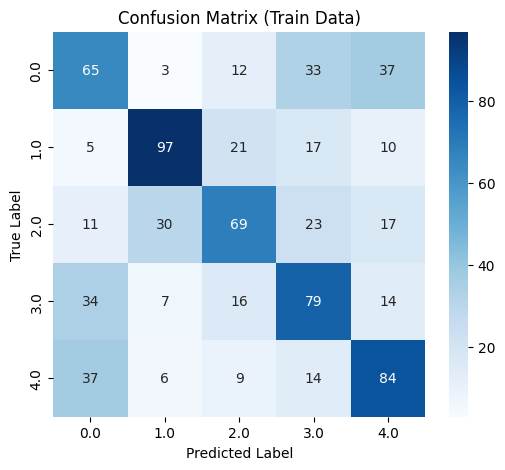

In [917]:
confusion_matrix_train(dfnn,task_3_data,task_3_label)

In [918]:
test_data = pd.read_csv("/content/drive/MyDrive/fodltemp/Task3_updated/team11/testing_data_set_11_data.csv", header = None)
test_label = pd.read_csv("/content/drive/MyDrive/fodltemp/Task3_updated/team11/testing_data_set_11_labels.csv", header = None)

In [919]:
print(test_data.shape)
print(test_label.shape)

(250, 36)
(250, 1)


Accuracy: 0.492


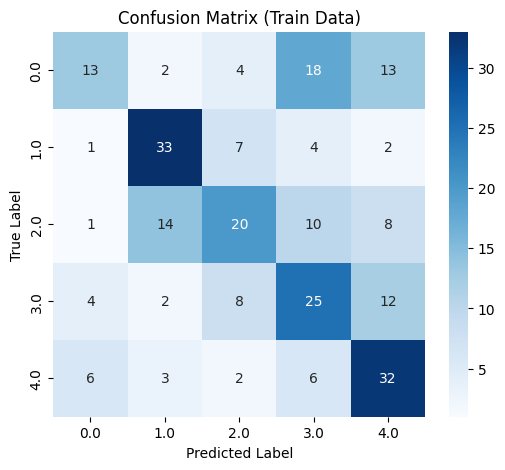

In [920]:
confusion_matrix_train(wdfnn,test_data,test_label)

Accuracy: 0.472


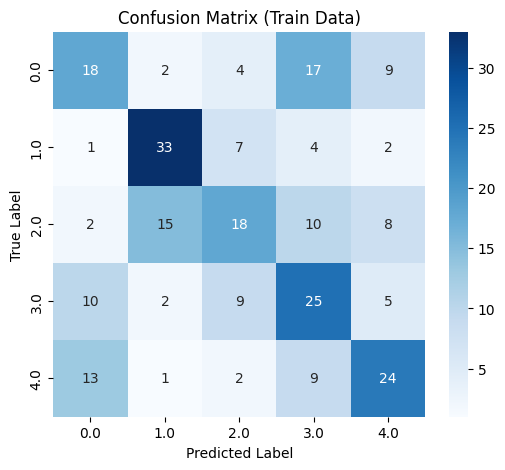

In [921]:
confusion_matrix_train(dfnn,test_data,test_label)